Epoch 1, Step 0, Loss: 547.7608032226562, Reconstruction Loss: 547.7565307617188, KL Loss: 0.0042507704347372055
Epoch 1, Step 100, Loss: 205.88565063476562, Reconstruction Loss: 202.38919067382812, KL Loss: 3.496459722518921
Epoch 1, Step 200, Loss: 186.09036254882812, Reconstruction Loss: 181.99462890625, KL Loss: 4.095739841461182
Epoch 1, Step 300, Loss: 180.66693115234375, Reconstruction Loss: 176.41168212890625, KL Loss: 4.255244731903076
Epoch 1, Step 400, Loss: 185.08848571777344, Reconstruction Loss: 181.09837341308594, KL Loss: 3.9901185035705566
Epoch 2, Step 0, Loss: 178.08084106445312, Reconstruction Loss: 173.9115447998047, KL Loss: 4.169301509857178
Epoch 2, Step 100, Loss: 173.98648071289062, Reconstruction Loss: 169.93731689453125, KL Loss: 4.049159049987793
Epoch 2, Step 200, Loss: 183.92230224609375, Reconstruction Loss: 179.951904296875, KL Loss: 3.9703922271728516
Epoch 2, Step 300, Loss: 180.25979614257812, Reconstruction Loss: 176.33839416503906, KL Loss: 3.92140

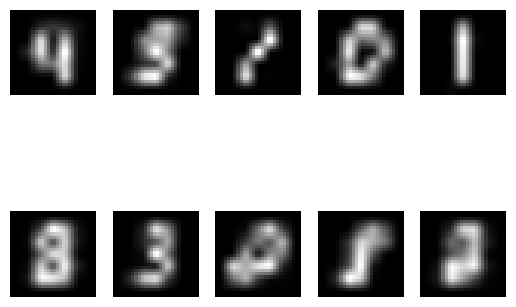

In [2]:
# Step-by-Step Guide to Implementing an SVAE

# Import Necessary Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the Dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define the Encoder Network
class Encoder(models.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')
        self.conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')
        self.flatten = layers.Flatten()
        self.fc_mu = layers.Dense(latent_dim)
        self.fc_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

# Define the Reparameterization Trick
def reparameterize(mu, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mu))
    z = mu + tf.exp(0.5 * log_var) * epsilon
    return z

# Define the Decoder Network
class Decoder(models.Model):
    def __init__(self, original_shape):
        super(Decoder, self).__init__()
        self.fc = layers.Dense(7 * 7 * 64, activation='relu')
        self.reshape = layers.Reshape((7, 7, 64))
        self.deconv1 = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')
        self.deconv2 = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')
        self.deconv3 = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')  # Final output layer
        self.resize = layers.Resizing(28, 28)  # Resize output to match the input image size (28x28)

    def call(self, inputs):
        x = self.fc(inputs)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.resize(x)  # Ensure the final output size is 28x28
        return x


# Define the Loss Function
def compute_loss(x, x_reconstructed, mu, log_var):
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis=[1, 2]))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1))
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

# Build the Complete SVAE Model
class SVAE(models.Model):
    def __init__(self, latent_dim, original_shape):
        super(SVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_shape)

    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var

# Set hyperparameters
latent_dim = 2
epochs = 10
batch_size = 128

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)

# Initialize the model
model = SVAE(latent_dim, original_shape=(28, 28, 1))
optimizer = tf.keras.optimizers.Adam()

# Training step
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        x_reconstructed, mu, log_var = model(x)
        loss, reconstruction_loss, kl_loss = compute_loss(x, x_reconstructed, mu, log_var)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, reconstruction_loss, kl_loss

# Training loop
for epoch in range(epochs):
    for step, x_batch in enumerate(train_dataset):
        loss, reconstruction_loss, kl_loss = train_step(x_batch)
        if step % 100 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {loss}, Reconstruction Loss: {reconstruction_loss}, KL Loss: {kl_loss}")

# Generate samples from the latent space and visualize
def generate_samples(model, num_samples=10):
    z = tf.random.normal([num_samples, latent_dim])
    samples = model.decoder(z)
    return samples

# Generate and plot some samples
samples = generate_samples(model)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()




In [3]:
# Let's create a downloadable .ipynb file with the provided code for the 3D Object Generation with VAEs project

from IPython.display import FileLink

# Define the content of the notebook
notebook_content = """
{
 "cells": [
  {
   "cell_type": "code",
   "execution_count": 1,
   "id": "1ab2e95e",
   "metadata": {},
   "outputs": [],
   "source": [
    "import tensorflow as tf\\n",
    "from tensorflow.keras import layers, models\\n",
    "import numpy as np\\n",
    "import matplotlib.pyplot as plt"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 2,
   "id": "2ba6a351",
   "metadata": {},
   "outputs": [],
   "source": [
    "# Placeholder for dataset loading (using synthetic data for simplicity)\\n",
    "def generate_synthetic_data(num_samples, grid_size=32):\\n",
    "    return np.random.randint(0, 2, size=(num_samples, grid_size, grid_size, grid_size))\\n",
    "\\n",
    "# Example: Generate 1000 samples of 3D voxel grids\\n",
    "X_train = generate_synthetic_data(1000)\\n",
    "X_train = X_train.astype('float32')  # Normalize the data\\n",
    "\\n",
    "# Visualize a sample voxel grid\\n",
    "fig = plt.figure()\\n",
    "ax = fig.add_subplot(111, projection='3d')\\n",
    "ax.voxels(X_train[0], edgecolors='k')\\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 3,
   "id": "e1fb0e76",
   "metadata": {},
   "outputs": [],
   "source": [
    "# Encoder network\\n",
    "def build_encoder(latent_dim=64, input_shape=(32, 32, 32, 1)):\\n",
    "    inputs = layers.Input(shape=input_shape)\\n",
    "    x = layers.Conv3D(32, 3, activation='relu', strides=2, padding='same')(inputs)\\n",
    "    x = layers.Conv3D(64, 3, activation='relu', strides=2, padding='same')(x)\\n",
    "    x = layers.Flatten()(x)\\n",
    "    x = layers.Dense(128, activation='relu')(x)\\n",
    "    \\n",
    "    # Latent space (mean and variance)\\n",
    "    z_mean = layers.Dense(latent_dim, name='z_mean')(x)\\n",
    "    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)\\n",
    "    \\n",
    "    return models.Model(inputs, [z_mean, z_log_var])\\n",
    "\\n",
    "# Decoder network\\n",
    "def build_decoder(latent_dim=64, output_shape=(32, 32, 32, 1)):\\n",
    "    latent_inputs = layers.Input(shape=(latent_dim,))\\n",
    "    x = layers.Dense(128, activation='relu')(latent_inputs)\\n",
    "    x = layers.Dense(8 * 8 * 8 * 64, activation='relu')(x)\\n",
    "    x = layers.Reshape((8, 8, 8, 64))(x)\\n",
    "    x = layers.Conv3DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)\\n",
    "    x = layers.Conv3DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)\\n",
    "    x = layers.Conv3DTranspose(1, 3, activation='sigmoid', padding='same')(x)\\n",
    "    \\n",
    "    return models.Model(latent_inputs, x)\\n",
    "\\n",
    "# VAE Model combining Encoder and Decoder\\n",
    "latent_dim = 64\\n",
    "encoder = build_encoder(latent_dim)\\n",
    "decoder = build_decoder(latent_dim)\\n",
    "\\n",
    "# Sampling function for reparameterization trick\\n",
    "def sampling(args):\\n",
    "    z_mean, z_log_var = args\\n",
    "    batch = tf.shape(z_mean)[0]\\n",
    "    dim = tf.shape(z_mean)[1]\\n",
    "    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))\\n",
    "    return z_mean + tf.exp(0.5 * z_log_var) * epsilon\\n",
    "\\n",
    "# Define the VAE model\\n",
    "inputs = layers.Input(shape=(32, 32, 32, 1))\\n",
    "z_mean, z_log_var = encoder(inputs)\\n",
    "z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])\\n",
    "decoded = decoder(z)\\n",
    "\\n",
    "vae = models.Model(inputs, decoded)\\n",
    "\\n",
    "# Loss function: Reconstruction + KL Divergence\\n",
    "def vae_loss(y_true, y_pred):\\n",
    "    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2, 3)))\\n",
    "    kl_loss = - 0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))\\n",
    "    return reconstruction_loss + kl_loss\\n",
    "\\n",
    "# Compile the model\\n",
    "vae.compile(optimizer='adam', loss=vae_loss)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 4,
   "id": "5b2bb270",
   "metadata": {},
   "outputs": [],
   "source": [
    "# Train the VAE\\n",
    "vae.fit(X_train, X_train, epochs=50, batch_size=32)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 5,
   "id": "dbb4c3d2",
   "metadata": {},
   "outputs": [],
   "source": [
    "# Generate and visualize new 3D objects\\n",
    "def generate_3d_objects(decoder, latent_dim, num_samples=5):\\n",
    "    z_samples = np.random.normal(size=(num_samples, latent_dim))\\n",
    "    generated_3d_objects = decoder.predict(z_samples)\\n",
    "    return generated_3d_objects\\n",
    "\\n",
    "# Generate and visualize new 3D objects\\n",
    "generated_objects = generate_3d_objects(decoder, latent_dim)\\n",
    "\\n",
    "# Visualize the first generated object\\n",
    "fig = plt.figure()\\n",
    "ax = fig.add_subplot(111, projection='3d')\\n",
    "ax.voxels(generated_objects[0].reshape(32, 32, 32), edgecolors='k')\\n",
    "plt.show()"
   ]
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".ipynb",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "version": "3.9.7"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 5
}
"""

# Write the content to a .ipynb file
file_path = "3D_Object_Generation_with_VAEs.ipynb"
with open(file_path, "w") as f:
    f.write(notebook_content)

# Provide the link to download the file
FileLink(file_path)


/content/3D_Object_Generation_with_VAEs.ipynb